In [2]:
import keras
import time
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from numpy import array
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras_vggface.vggface import VGGFace
from keras.models import Model, Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout

In [3]:
imgs = glob.glob("data/one_faces/*.jpg")

In [4]:
# imgs = imgs + (glob.glob("data/one_faces/*.jpg"))
imgs = np.array([img[15:] for img in imgs])

In [5]:
faces_imgs = np.load("faces_imgs.npy")
faces_annot = np.load("faces_annot.npy")[0]

In [29]:
pred = np.load("PRED.npy")[0]

In [30]:
for key in pred.keys():
    pred[key] = pred[key].astype(int)

In [10]:
def get_face_id(img):
    faces = []
    for i in faces_imgs:
        if i[1] == img:
            faces.append(i[0])
    return np.array(faces)

In [11]:
def get_id_coord(img):
    W, H = 100, 100
    coord = [] 
    ids = get_face_id(img[5:])
    for i in ids:
        coord.append(faces_annot[int(i)])
    a = np.array(coord, dtype=np.float32).reshape(-1, 4)
    a = a[a[:,0].argsort()]
    a[:, 0] /= W 
    a[:, 1] /= H
    a[:, 2] /= H
    a[:, 3] /= W

    a = np.append(arr = np.ones((len(a), 1)), values= a, axis = 1).reshape(-1, 5)
    return a

In [12]:
def get_images(imgName):

    W, H = (Image.open(imgName)).size
    import os
    os.system("cp %s darknet-master/" % imgName)
    os.chdir("darknet-master/")
    os.system("./darknet detect cfg/yolo.cfg yolo.weights %s" % imgName)
    file = open("Predictions.txt")
    coord = []
    for line in file.readlines():
        coord.append(line.strip().split(" "))
    coord = np.array(coord).astype(float)
    os.chdir("../")
    file.seek(0)
    file.close()
    coord[:, 0] = coord[:, 0] / H
    coord[:, 1] = coord[:, 1] / H
    coord[:, 2] = coord[:, 2] / W
    coord[:, 3] = coord[:, 3] / W
    return np.append(arr = np.ones((len(coord), 1)) , values = coord, axis = 1).reshape(-1, 5)

In [13]:
K.set_learning_phase(1)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
sess = tf.Session()

X = tf.placeholder(dtype = tf.float32, shape = (1, 100, 100, 3))
Y = tf.placeholder(dtype = tf.float32, shape = (None, 5))

In [14]:
vgg = VGGFace(include_top=False, input_tensor = X, input_shape=(100, 100, 3))
for layer in vgg.layers:
    layer.trainable = False

In [15]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 100, 100, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 100, 100, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 50, 50, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 25, 128)       0         
__________

In [16]:
p1 = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(vgg.get_layer(index=11).output)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p21 = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(vgg.get_layer(index=13).output)
p2 = BatchNormalization()(p21)
p2 = Activation('relu')(p2)

p101 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p102 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)
p102 = BatchNormalization()(p102)
# p102 = Activation('relu')(p102)
# p102 = Activation('sigmoid')(p102)
p201 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p202 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)
p202 = BatchNormalization()(p202)
# p202 = Activation('relu')(p202)
# p202 = Activation('sigmoid')(p202)


# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p111 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p112 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)
p112 = BatchNormalization()(p112)
# p112 = Activation('relu')(p112)
# p112 = Activation('sigmoid')(p112)
p211 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p212 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)
p212 = BatchNormalization()(p212)
# p212 = Activation('relu')(p212)
# p212 = Activation('sigmoid')(p212)

# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p121 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p122 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)
p122 = BatchNormalization()(p122)
# p122 = Activation('relu')(p122)
# p122 = Activation('sigmoid')(p122)
p221 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p222 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)
p222 = BatchNormalization()(p222)
# p222 = Activation('relu')(p222)
# p222 = Activation('sigmoid')(p222)

# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p131 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p132 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)
p132 = BatchNormalization()(p132)
# p132 = Activation('relu')(p132)
# p132 = Activation('sigmoid')(p132)
p231 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p232 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)
p232 = BatchNormalization()(p232)
# p232 = Activation('relu')(p232)
# p232 = Activation('sigmoid')(p232)

# Combine All Predictions

p102 = K.concatenate(tensors=[p101, p102], axis = -1)
p202 = K.concatenate(tensors=[p201, p202], axis = -1)

p112 = K.concatenate(tensors=[p111, p112], axis = -1)
p212 = K.concatenate(tensors=[p211, p212], axis = -1)

p122 = K.concatenate(tensors=[p121, p122], axis = -1)
p222 = K.concatenate(tensors=[p221, p222], axis = -1)

p132 = K.concatenate(tensors=[p131, p132], axis = -1)
p232 = K.concatenate(tensors=[p231, p232], axis = -1)

In [17]:
pred = [K.reshape(p102, (-1, 5)),
        K.reshape(p202, (-1, 5)),
        K.reshape(p112, (-1, 5)),
        K.reshape(p212, (-1, 5)),
        K.reshape(p122, (-1, 5)),
        K.reshape(p222, (-1, 5)),
        K.reshape(p132, (-1, 5)),
        K.reshape(p232, (-1, 5))
       ]

In [18]:
pred = K.concatenate(pred, axis = 0)

In [19]:
def NMS(boxes = pred):    
    Z0 = tf.image.non_max_suppression(boxes=K.reshape(boxes[:, 1:], (-1, 4)), scores=K.reshape(boxes[:, 0], (-1, )),
                                        max_output_size=25, iou_threshold=0.55)
    A = K.reshape(tf.gather_nd(boxes, K.reshape(Z0, (-1, 1))), (-1, 5))
    return A

In [20]:
def loss(Y, y, a=0.8):
    if tf.size(Y) != tf.size(y):
        n = tf.truncatediv(tf.size(Y),  K.constant(value = 5, dtype=tf.int32))
        y_ = y[:n]
        
    softMax = K.mean(-(Y[:, 0] * K.log(y_[:, 0]) + (1 - Y[:, 0]) * K.log(1 - y_[:, 0]))) + 1.5 * K.mean(-(tf.zeros_like(y[n:])[:, 0] * K.log(y[n:][:, 0]) + (1 - tf.zeros_like(y[n:])[:, 0]) * K.log(1 - y[n:][:, 0])))
    mse = K.mean(K.square(Y[:, 1:] - y_[:, 1:]))
    return 1.25 * softMax + 1.5 * mse

In [21]:
bbox = tf.abs(NMS())

In [22]:
cost = loss(Y, bbox)

In [23]:
opt = tf.train.AdamOptimizer(learning_rate=0.0000001)
train_ = opt.minimize(cost)

In [24]:
sess.run(tf.global_variables_initializer())

In [25]:
saver = tf.train.Saver()

In [26]:
def train(ID, it, epochs = 10):
    for e in range(epochs):
        loss = 0.0
        for i in range(len(imgs)):
            _, L = sess.run([train_, cost], feed_dict={X: np.expand_dims(np.resize(np.array(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS))/255, (100, 100, 3)), axis = 0), Y: pred[imgs[i]].reshape(-1, 5)})       
            loss += L
            if i % 25 == 0:
                print("iter {} loss: {}".format(i, L))
#                 saver.save(sess, save_path="checkpoints/epoch_{}_iter_{}.ckpt".format(e, i))
        print("\\\\\\\\\\\\\\\\\\\\\\\\")
        print("epoch {} , avg_loss {}".format(e, loss/len(imgs)))

In [ ]:
train(0, 0, 50)

iter 0 loss: 5.307806015014648
iter 25 loss: 3.6003811359405518
iter 50 loss: 6.735546112060547
iter 75 loss: 2.9271626472473145
iter 100 loss: 3.430464506149292
iter 125 loss: 3.1566243171691895
\\\\\\\\\\\\
epoch 0 , avg_loss 4.461904991918535
iter 0 loss: 4.357659816741943
iter 25 loss: 3.418025493621826
iter 50 loss: 5.427222728729248
iter 75 loss: 2.7950239181518555
iter 100 loss: 2.9114224910736084
iter 125 loss: 2.9056568145751953
\\\\\\\\\\\\
epoch 1 , avg_loss 4.022362080972586
iter 0 loss: 3.9050981998443604
iter 25 loss: 3.219780445098877
iter 50 loss: 4.975425720214844
iter 75 loss: 2.6840312480926514
iter 100 loss: 2.6305346488952637
iter 125 loss: 2.7724404335021973
\\\\\\\\\\\\
epoch 2 , avg_loss 3.791060655864317
iter 0 loss: 3.613970994949341
iter 25 loss: 3.0282318592071533
iter 50 loss: 4.626241683959961
iter 75 loss: 2.5838961601257324
iter 100 loss: 2.4895405769348145
iter 125 loss: 2.6666626930236816
\\\\\\\\\\\\
epoch 3 , avg_loss 3.5608414464922094
iter 0 loss: 

In [29]:
def plot_box(box, img):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    %matplotlib inline
    p, t, b, l, r = box
    im = np.array(Image.open(img), dtype=np.uint8)
    H, W = Image.open(img).size
    fig,ax = plt.subplots(1)

    ax.imshow(im)

    rect = patches.Rectangle((t*H,l*W),np.abs((r - l)*W),np.abs((t - b)*H),linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

    plt.show()

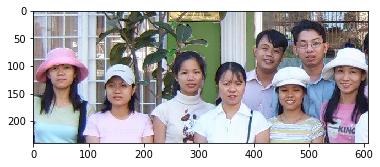

[[0.98495495 0.41854885 0.971431   0.13939095 0.3389859 ]
 [0.9651482  0.8980298  0.615898   0.6176397  0.31583077]
 [0.8052851  0.8584645  1.5332682  0.8538966  0.7685566 ]
 [0.7644187  0.21569085 0.5381042  0.05966635 0.96355146]
 [0.76106054 0.9119104  0.65050757 0.16951668 0.5473065 ]
 [0.73550665 1.7554587  0.07813859 1.8314174  1.5738783 ]
 [0.7284761  1.6196067  0.00416976 0.3856907  0.54502815]
 [0.72285736 1.2198209  1.5765952  0.412245   0.47898018]
 [0.68023247 0.02781481 0.27915525 0.2229478  0.5832448 ]
 [0.6746647  2.1185     0.8710472  1.1640267  0.3111987 ]
 [0.6676007  0.03846979 0.4347334  0.07677797 0.8752403 ]
 [0.6508189  0.5450063  1.4252464  2.395864   0.6822107 ]
 [0.6461498  0.6376297  0.36398995 1.4150593  0.6338825 ]
 [0.63255936 0.73717403 1.2329962  0.23479441 1.9743669 ]
 [0.62423015 1.3372145  1.2986968  0.89223826 0.80158633]
 [0.622463   1.1649785  0.34824523 0.27470705 0.60816747]
 [0.6222519  0.51659817 0.5096076  0.22313523 0.5462315 ]
 [0.6221585  0

In [35]:
g = 52
d = sess.run(bbox, feed_dict={X: np.expand_dims(np.resize(np.array(Image.open(imgs[g]).resize((100, 100), Image.ANTIALIAS))/255, (100, 100, 3)), axis = 0)})
plot_box(d[5], imgs[g])
print(d)

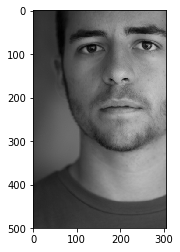

In [109]:
plot_box(np.abs(d[1]), imgs[1])

In [86]:
d = np.expand_dims(np.resize(np.array(Image.open(imgs[0]).resize((400, 275), Image.ANTIALIAS))/255, (275, 400, 3)), axis = 0)

In [87]:
d.shape

(1, 275, 400, 3)

In [37]:
pred = np.load("PRED.npy")

In [47]:
dict(np.array({}))

TypeError: iteration over a 0-d array

In [22]:
for img in imgs:
    pred[img] = get_images(img)

In [67]:
def correct_coord(imgName, pred):
    W, H = Image.open(imgName).size
    coord = pred[imgName]
    coord[:, 1] = coord[:, 1] * H/608
    coord[:, 2] = coord[:, 2] * H/608
    coord[:, 3] = coord[:, 3] * W/608
    coord[:, 4] = coord[:, 4] * W/608
    pred[imgName] = coord

In [68]:
for img in pred.keys():
    correct_coord(img, pred)

In [69]:
pred

{'1.jpg': array([[1.00000001, 0.21381579, 0.31414474, 0.12993421, 0.16282895],
        [1.00000001, 0.01809211, 0.32072369, 0.        , 0.21381579]]),
 '10.jpg': array([[1.00000001, 0.21381579, 0.31414474, 0.12993421, 0.16282895],
        [1.00000001, 0.01809211, 0.32072368, 0.        , 0.21381579]]),
 '100.jpg': array([[1.        , 0.21381579, 0.31414473, 0.12993421, 0.16282895],
        [1.        , 0.01809211, 0.32072369, 0.        , 0.21381579]]),
 '101.jpg': array([[1.00000002, 0.21381579, 0.31414474, 0.12993421, 0.16282895],
        [1.00000002, 0.01809211, 0.32072368, 0.        , 0.21381579]]),
 '102.jpg': array([[1.        , 0.21381579, 0.31414474, 0.12993421, 0.16282895],
        [1.        , 0.01809211, 0.32072368, 0.        , 0.21381579]]),
 '103.jpg': array([[1.        , 0.21381579, 0.31414474, 0.12993421, 0.16282895],
        [1.        , 0.01809211, 0.32072368, 0.        , 0.21381579]]),
 '104.jpg': array([[0.99999999, 0.21381579, 0.31414474, 0.12993421, 0.16282895],
    

In [70]:
PRED = np.array([pred])

In [71]:
np.save("PRED", PRED)

In [73]:
pred[imgs[0]].shape

(2, 5)